In [1]:
import pandas as pd
import graph_ruggedness_de
import matplotlib.pyplot as plt 
import networkx as nx
import numpy as np
import sequence_evolution
from ete3 import Tree
import ete3
import random
import pyvolve
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import brownian_motion
import matplotlib.colors as mcolors
from scipy.stats import spearmanr
import nk_landscape
from scipy import stats
import seaborn as sns

QMetaType::registerTypedef: -- Type name 'PyQt_PyObject' previously registered as typedef of 'PyQt_PyObject' [1024], now registering as typedef of '' [-17958193].


### Sequence evolution simulation
The below cell simulates the simulation of amino acid sequences, drawing parameters from uniform distributions of realistic values. The cell has also been converted to functional code in `src.sequence_evolution.sample_sequences`. The output is a dictionary of Dirichlet energies over the first 50 eigenvectors of the simulated graph Laplacian, simulating the fitness function as increasingly rugged.

In [42]:
dir_dict = {}
prob_dict = {}
sample_dict = {}

sample_size = 1
for _ in tqdm(enumerate(range(sample_size))):
    try:

        num_nodes = int(np.random.uniform(50, 2000))
        mean_branch_length = np.random.uniform(0.01, 0.5)
        std_dev_branch_length = np.random.uniform(0.001, 0.1)
        alpha = np.random.uniform(0.1, 0.5)
        model = random.choice(('WAG', 'LG'))
        rate_categoies = 4
        sequence_length = int(np.random.uniform(100, 600))

        sample_info = {
            'num_nodes' : num_nodes,
            'mean_branch_length' : mean_branch_length,
            'std_dev_branch_length' : std_dev_branch_length,
            'alpha' : alpha,
            'model' : model,
            'sequence_length' : sequence_length
        }

        seq_dict = sequence_evolution.sequence_evolution(num_nodes=num_nodes,
                                                        mean_branch_length=mean_branch_length,
                                                        std_dev_branch_length=std_dev_branch_length,
                                                        alpha=alpha,
                                                        model=model,
                                                        rate_categories=rate_categoies,
                                                        sequence_length=sequence_length
                                                        )
        seq_ls = list(seq_dict.values())
        values = [0]*len(seq_ls)
        G = graph_ruggedness_de.build_ohe_graph(seq_ls=seq_ls,
                                            values=values)
        eign_prob_dict = {}
        eign_dir_dict = {}
        for eign in list(range(1)):
            G = graph_ruggedness_de.compute_elementary_landscape(G=G, n=eign)
            dir_energy = graph_ruggedness_de.compute_dirichlet_energy(G=G)
            eign_dir_dict[eign] = dir_energy
        
        dir_dict[_] = eign_dir_dict
        prob_dict[_] = eign_prob_dict
        sample_dict[_] = sample_info
    
    except:
        continue


Computing OHE dictionary.: 20it [00:00, 212908.83it/s]
Adding nodes to graph.: 536it [00:00, 19655.41it/s]


Computing all vs. all OHE distance matrix.
Done.
Fitting all vs. all OHE distance model.
Done.


Adding KNN edges.: 536it [00:00, 78063.37it/s]
1it [00:07,  7.52s/it]


### Graph structure and fitness distribution
The below cell plots graphs for with simulated fitness signals as the first and 50th eigenvectors of the same graph Laplacian. The includes both a computation of the dirichlet energy and the distribution of fitnesses. 

Computing OHE dictionary.: 20it [00:00, 105120.40it/s]
Adding nodes to graph.: 536it [00:00, 17870.80it/s]


Computing all vs. all OHE distance matrix.
Done.
Fitting all vs. all OHE distance model.
Done.


Adding KNN edges.: 536it [00:00, 77882.18it/s]
/Users/matthewspence/Documents/Documents/graph-ruggedness-de/src/brownian_motion.py:162: RuntimeWarning: Mean of empty slice
  avg_neighbor_signal = np.nanmean([G.nodes[neighbor]['value'] for neighbor in neighbors])
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_22157/2733020470.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)


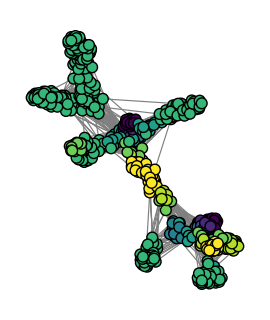

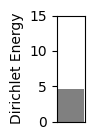

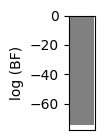

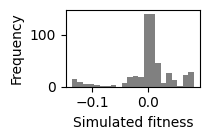

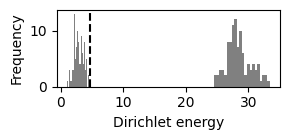

/Users/matthewspence/Documents/Documents/graph-ruggedness-de/src/brownian_motion.py:162: RuntimeWarning: Mean of empty slice
  avg_neighbor_signal = np.nanmean([G.nodes[neighbor]['value'] for neighbor in neighbors])
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_22157/2733020470.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)


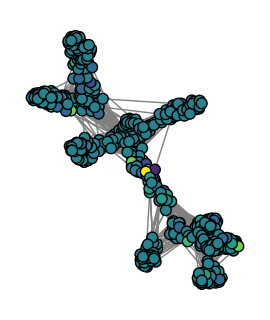

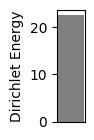

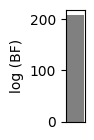

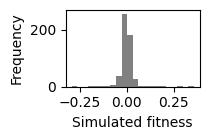

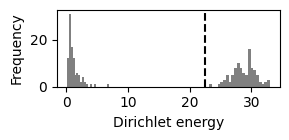

In [46]:
seq_ls = list(seq_dict.values())
values = [0]*len(seq_ls)
G = graph_ruggedness_de.build_ohe_graph(seq_ls=seq_ls,
                                    values=values)

G_elem = graph_ruggedness_de.compute_elementary_landscape(G,
                                                 10)
pos = nx.spring_layout(G)

dir_energy = graph_ruggedness_de.compute_dirichlet_energy(G=G_elem)


h0_prior_arr = brownian_motion.sample_prior_dist(G=G_elem, ruggedness_fn=graph_ruggedness_de.compute_dirichlet_energy, sample_size=0.1)
h1_prior_arr = brownian_motion.sample_rugged_prior_dist(G=G_elem, ruggedness_fn=graph_ruggedness_de.compute_dirichlet_energy)
marginal_likelihood = brownian_motion.compute_marginal_likelihoods(h0_array=h0_prior_arr, h1_array=h1_prior_arr, empirical_val=dir_energy)

values = [node[1]['value'] for node in G_elem.nodes(data=True)]
viridis = plt.cm.get_cmap('viridis', 10)
node_colors = [viridis((value - min(values)) / (max(values) - min(values))) for value in values]


plt.figure(figsize=(2.5, 3))
nx.draw(G_elem, pos, node_color=node_colors, with_labels=False, edgecolors='black', node_size=60, width=0.85, edge_color='grey')
plt.savefig('figures/Figure_1/0th_eigvector_graph.pdf')
plt.show()

plt.figure(figsize=(1.05, 1.5))
plt.bar(x=0, height=dir_energy, color='grey')
plt.xticks([])
plt.ylim(0, 15)
plt.ylabel('Dirichlet Energy')
plt.tight_layout()
plt.savefig('figures/Figure_1/eigenvector_1_DE.pdf')
plt.show()

plt.figure(figsize=(1.15, 1.5))
plt.bar(x=0, height=marginal_likelihood, color='grey')
plt.xticks([])
plt.ylabel('log (BF)')
plt.tight_layout()
plt.savefig('figures/Figure_1/eigenvector_1_logp.pdf')
plt.show()

plt.figure(figsize=(2.2, 1.5))
plt.hist(values, bins=22, color='grey')
plt.xlabel('Simulated fitness')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('figures/Figure_1/eigenvector_1_hist.pdf')
plt.show()

plt.figure(figsize=(3, 1.5))
plt.hist(h0_prior_arr, bins=22, color='grey', zorder=1)
plt.hist(h1_prior_arr, bins=22, color='grey', zorder=1)
plt.xlabel('Dirichlet energy')
plt.ylabel('Frequency')
plt.axvline(dir_energy, linestyle = '--', color='black', zorder=2)
plt.tight_layout()
plt.savefig('figures/Figure_1/eigenvector_1_hist_prior_arr.pdf')
plt.show()

G_elem = graph_ruggedness_de.compute_elementary_landscape(G,
                                                 100)
dir_energy = graph_ruggedness_de.compute_dirichlet_energy(G=G_elem)


h0_prior_arr = brownian_motion.sample_prior_dist(G=G_elem, ruggedness_fn=graph_ruggedness_de.compute_dirichlet_energy, sample_size=0.1)
h1_prior_arr = brownian_motion.sample_rugged_prior_dist(G=G_elem, ruggedness_fn=graph_ruggedness_de.compute_dirichlet_energy)
marginal_likelihood = brownian_motion.compute_marginal_likelihoods(h0_array=h0_prior_arr, h1_array=h1_prior_arr, empirical_val=dir_energy)

values = [node[1]['value'] for node in G_elem.nodes(data=True)]
viridis = plt.cm.get_cmap('viridis', 10)
node_colors = [viridis((value - min(values)) / (max(values) - min(values))) for value in values]


plt.figure(figsize=(2.5, 3))
nx.draw(G_elem, pos, node_color=node_colors, with_labels=False, edgecolors='black', node_size=60, width=1, edge_color='grey')
plt.savefig('figures/Figure_1/50th_eigvector_graph.pdf')
plt.show()

plt.figure(figsize=(1.05, 1.5))
plt.bar(x=0, height=dir_energy, color='grey')
plt.xticks([])
plt.ylabel('Dirichlet Energy')
plt.tight_layout()
plt.savefig('figures/Figure_1/eigenvector_50_DE.pdf')
plt.show()

plt.figure(figsize=(1.05, 1.5))
plt.bar(x=0, height=marginal_likelihood, color='grey')
plt.xticks([])
plt.ylabel('log (BF)')
plt.tight_layout()
plt.savefig('figures/Figure_1/eigenvector_50_logp.pdf')
plt.show()

plt.figure(figsize=(2.2, 1.5))
plt.hist(values, bins=22, color='grey')
plt.xlabel('Simulated fitness')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('figures/Figure_1/eigenvector_50_hist.pdf')
plt.show()

plt.figure(figsize=(3, 1.5))
plt.hist(h0_prior_arr, bins=22, color='grey', zorder=1)
plt.hist(h1_prior_arr, bins=22, color='grey', zorder=1)
plt.xlabel('Dirichlet energy')
plt.ylabel('Frequency')
plt.axvline(dir_energy, linestyle = '--', color='black', zorder=2)
plt.tight_layout()
plt.savefig('figures/Figure_1/eigenvector_50_hist_prior_arr.pdf')
plt.show()

## NK-Landscape simulation

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_22157/4146169271.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)


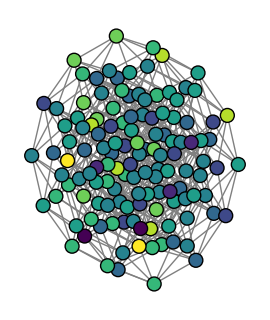

In [41]:
Gnk = nk_landscape.generate_nk_landscape_amino_acids(N=7, K=6, amino_acids=['A', 'D'])

values = [node[1]['value'] for node in Gnk.nodes(data=True)]
viridis = plt.cm.get_cmap('viridis', 10)
node_colors = [viridis((value - min(values)) / (max(values) - min(values))) for value in values]

plt.figure(figsize=(2.5, 3))
nx.draw(Gnk, node_color=node_colors, with_labels=False, edgecolors='black', node_size=100, width=1, edge_color='grey')
plt.savefig('figures/Figure_1/NK_landscape_k6.pdf')
plt.show()

In [31]:
rep_dict = {}
rep_de_dict = {}
rep_sample_info_dict = {}

#Iterate through landscape simulations.
for _ in range(10):
    
    de_logprob_dict = {}
    de_dict = {}
    k_list = list(range(6))
    
    #Iterate through Laplacian eigenvectors.
    for k in k_list:

        Gnk = nk_landscape.generate_nk_landscape_amino_acids(N=7, K=k, amino_acids=['A', 'D'])
          
        #Compute energy.
        dir_energy = graph_ruggedness_de.compute_dirichlet_energy(G=Gnk)
        
        h0_prior_arr = brownian_motion.sample_prior_dist(G=Gnk,
                                                ruggedness_fn=graph_ruggedness_de.compute_dirichlet_energy,
                                                local=False,
                                                replicates=100)
        
        h1_prior_arr = brownian_motion.sample_rugged_prior_dist(G=Gnk,
                                                                ruggedness_fn=graph_ruggedness_de.compute_dirichlet_energy,
                                                                local=False,
                                                                replicates=100)
        
        #Save -log(P) to dictionary with eigenvector idx and sampling prop.
        de_logprob_dict[k] = brownian_motion.compute_marginal_likelihoods(h0_array=h0_prior_arr,
                                                                            h1_array=h1_prior_arr,
                                                                            empirical_val=dir_energy)
        
        
        #Save dirichlet energy to dictionary with eigenvector idx.
        de_dict[k] = dir_energy

    #Store -log(P) information to dictionary per replicate.
    rep_dict[_] = de_logprob_dict
    
    #Store Dirichlet energy to dictionary per replicate.
    rep_de_dict[_] = de_dict

/Users/matthewspence/Documents/Documents/graph-ruggedness-de/src/brownian_motion.py:162: RuntimeWarning: Mean of empty slice
  avg_neighbor_signal = np.nanmean([G.nodes[neighbor]['value'] for neighbor in neighbors])


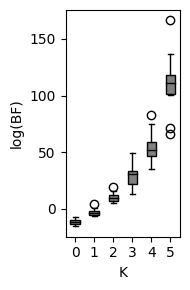

In [32]:
data_list = []

# Iterate over the replicates and K parameters
for replicate, k_dict in rep_dict.items():
    for k_param, bf_value in k_dict.items():
        data_list.append({'replicate': replicate, 'K_parameter': k_param, 'BF': bf_value})

# Create a DataFrame from the list
df = pd.DataFrame(data_list)

# Convert K_parameter to integer and sort the DataFrame
df['K_parameter'] = df['K_parameter'].astype(int)
df = df.sort_values(['K_parameter', 'replicate'])

# Get the sorted list of unique K parameters
k_parameters = sorted(df['K_parameter'].unique())

# Prepare the data for the boxplot
data_to_plot = [df[df['K_parameter'] == k]['BF'].values for k in k_parameters]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(2, 3))

# Create the boxplot
bp = ax.boxplot(data_to_plot, positions=range(len(k_parameters)), patch_artist=True)

# Customize the boxplot appearance
for box in bp['boxes']:
    box.set(facecolor='grey', edgecolor='black')

for whisker in bp['whiskers']:
    whisker.set(color='black')

for cap in bp['caps']:
    cap.set(color='black')

for median in bp['medians']:
    median.set(color='black')


# Add labels and title
ax.set_xlabel('K')
ax.set_ylabel('log(BF)')

# Adjust layout
plt.tight_layout()
plt.savefig('figures/Figure_1/NK_BF_boxplot.pdf')
plt.show()

### Summary statistics

In [75]:
import scipy.stats as stats

# Group BF values by K_parameter
groups = [df[df['K_parameter'] == k]['BF'].values for k in k_parameters]

# Perform ANOVA
f_stat, p_value = stats.f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat}, p-value: {p_value}")

import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(df['BF'], df['K_parameter'])
post_hoc_res = comp.tukeyhsd()
print(post_hoc_res.summary())

ANOVA F-statistic: 99.37690336917163, p-value: 5.677581347512203e-26
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     0      1    8.615 0.7599 -10.3372  27.5672  False
     0      2  22.0372 0.0138    3.085  40.9894   True
     0      3  41.9689    0.0  23.0167  60.9211   True
     0      4  66.6759    0.0  47.7237  85.6281   True
     0      5 121.6907    0.0 102.7385 140.6429   True
     1      2  13.4222 0.3066    -5.53  32.3744  False
     1      3  33.3539    0.0  14.4017  52.3061   True
     1      4  58.0609    0.0  39.1087  77.0131   True
     1      5 113.0757    0.0  94.1235 132.0279   True
     2      3  19.9317 0.0339   0.9795  38.8839   True
     2      4  44.6387    0.0  25.6865  63.5909   True
     2      5  99.6535    0.0  80.7012 118.6057   True
     3      4   24.707  0.004   5.7548  43.6592   True
     3      5  79.7218    0.0  60.7695   98.674   T

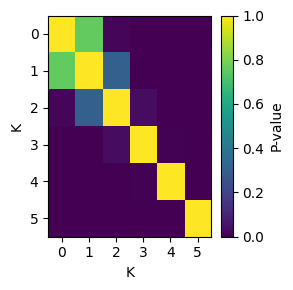

In [91]:
# Define the groups and p-values
groups = [0, 1, 2, 3, 4, 5]
p_values = post_hoc_res.pvalues

# Create an empty 6x6 matrix for storing p-values
matrix_size = len(groups)
p_matrix = np.ones((matrix_size, matrix_size))  # Initialize with 1s (since diagonal is self-comparison)

# Define group1 and group2 pairs based on the provided comparison order
group1 = [0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4]
group2 = [1, 2, 3, 4, 5, 2, 3, 4, 5, 3, 4, 5, 4, 5, 5]

# Fill in the p-values into the appropriate positions
for g1, g2, p in zip(group1, group2, p_values):
    p_matrix[g1, g2] = p
    p_matrix[g2, g1] = p  # Ensure symmetry

# Create a heatmap using imshow
    
fig = plt.subplots(figsize=(3, 3))

plt.imshow(p_matrix, cmap='viridis', aspect='auto', vmin=0, vmax=1)

# Add a colorbar with a label
plt.colorbar(label='P-value')

# Add tick labels for the groups
plt.xticks(ticks=range(matrix_size), labels=groups)
plt.yticks(ticks=range(matrix_size), labels=groups)

# Add labels for better clarity
plt.xlabel('K')
plt.ylabel('K')

# Display the heatmap
plt.tight_layout()
plt.savefig('figures/Figure_1/tukey_HSD_NK_landscape.pdf')
plt.show()

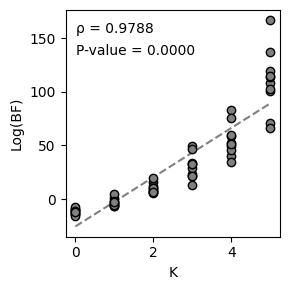

In [107]:


# Compute Spearman rho correlation
rho, p_value = spearmanr(df['K_parameter'], df['BF'])

# Fit a line of best fit (you can use np.polyfit for linear regression)
slope, intercept = np.polyfit(df['K_parameter'], df['BF'], 1)
best_fit_line = np.array(df['K_parameter']) * slope + intercept

fig = plt.subplots(figsize=(3, 3))

plt.xlabel('K')
plt.ylabel('Log(BF)')

# Plot the line of best fit first (so it appears behind the scatter plot)
plt.plot(df['K_parameter'], best_fit_line, color='grey', linestyle='--', zorder=1)

# Scatter plot with color based on eigenvalue index
plt.scatter(df['K_parameter'], df['BF'], color='grey', linewidths=1, edgecolors='black')
plt.text(0.05, 0.9, f'ρ = {rho:.4f}', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.05, 0.8, f'P-value = {p:.4f}', transform=plt.gca().transAxes, fontsize=10)

plt.tight_layout()
plt.savefig('figures/Figure_1/K_vs_BF_NK_landscape.pdf')
plt.show()

## Sampling with Diffusion


In [108]:
rep_dict = {}
rep_de_dict = {}
rep_sample_info_dict = {}

#Iterate through landscape simulations.
for _ in range(5):
    #Sample evolutionary parameters.
    num_nodes = int(np.random.uniform(200, 500))
    mean_branch_length = np.random.uniform(0.01, 0.5)
    std_dev_branch_length = np.random.uniform(0.001, 0.1)
    alpha = np.random.uniform(0.1, 0.5)
    model = random.choice(('WAG', 'LG'))
    rate_categoies = 4
    sequence_length = int(np.random.uniform(100, 600))

    sample_info = {
        'num_nodes' : num_nodes,
        'mean_branch_length' : mean_branch_length,
        'std_dev_branch_length' : std_dev_branch_length,
        'alpha' : alpha,
        'model' : model,
        'sequence_length' : sequence_length
    }
    

    #Perform sequence evolution.
    seq_dict = sequence_evolution.sequence_evolution(num_nodes=num_nodes,
                                                    mean_branch_length=mean_branch_length,
                                                    std_dev_branch_length=std_dev_branch_length,
                                                    alpha=alpha,
                                                    model=model,
                                                    rate_categories=rate_categoies,
                                                    sequence_length=sequence_length
                                                    )
    #Construct graph from simulated sequences.

    seq_ls = list(seq_dict.values())
    values = [0]*len(seq_ls)
    G = graph_ruggedness_de.build_ohe_graph(seq_ls=seq_ls,
                                        values=values)
    de_logprob_dict = {}
    de_dict = {}
    
    eign_list = list(range(20))
    
    #Iterate through Laplacian eigenvectors.
    for eign in eign_list:
        
        #Assign fitness scores as eigenvectors.
        G = graph_ruggedness_de.compute_elementary_landscape(G=G, n=eign)
        
        #Compute energy.
        dir_energy = graph_ruggedness_de.compute_dirichlet_energy(G=G)
        
        h0_prior_arr = brownian_motion.sample_prior_dist(G=G,
                                                ruggedness_fn=graph_ruggedness_de.compute_dirichlet_energy,
                                                local=False,
                                                replicates=100)
        
        h1_prior_arr = brownian_motion.sample_rugged_prior_dist(G=G,
                                                                ruggedness_fn=graph_ruggedness_de.compute_dirichlet_energy,
                                                                local=False,
                                                                replicates=100)
        
        #Save -log(P) to dictionary with eigenvector idx and sampling prop.
        de_logprob_dict[eign] = brownian_motion.compute_marginal_likelihoods(h0_array=h0_prior_arr,
                                                                            h1_array=h1_prior_arr,
                                                                            empirical_val=dir_energy)
        
        
        #Save dirichlet energy to dictionary with eigenvector idx.
        de_dict[eign] = dir_energy


    #Store evolutionary parameters.
    rep_sample_info_dict[_] = sample_info

    #Store -log(P) information to dictionary per replicate.
    rep_dict[_] = de_logprob_dict
    
    #Store Dirichlet energy to dictionary per replicate.
    rep_de_dict[_] = de_dict


Computing OHE dictionary.: 20it [00:00, 235635.06it/s]
Adding nodes to graph.: 394it [00:00, 18087.80it/s]


Computing all vs. all OHE distance matrix.
Done.
Fitting all vs. all OHE distance model.
Done.


Adding KNN edges.: 394it [00:00, 103200.89it/s]

Connecting components



/Users/matthewspence/Documents/Documents/graph-ruggedness-de/src/brownian_motion.py:162: RuntimeWarning: Mean of empty slice
  avg_neighbor_signal = np.nanmean([G.nodes[neighbor]['value'] for neighbor in neighbors])
Computing OHE dictionary.: 20it [00:00, 259709.23it/s]
Adding nodes to graph.: 390it [00:00, 9779.10it/s]


Computing all vs. all OHE distance matrix.
Done.
Fitting all vs. all OHE distance model.
Done.


Adding KNN edges.: 390it [00:00, 102389.74it/s]
/Users/matthewspence/Documents/Documents/graph-ruggedness-de/src/brownian_motion.py:162: RuntimeWarning: Mean of empty slice
  avg_neighbor_signal = np.nanmean([G.nodes[neighbor]['value'] for neighbor in neighbors])
Computing OHE dictionary.: 20it [00:00, 237637.62it/s]
Adding nodes to graph.: 268it [00:00, 10303.34it/s]


Computing all vs. all OHE distance matrix.
Done.
Fitting all vs. all OHE distance model.
Done.


Adding KNN edges.: 268it [00:00, 115065.36it/s]

Connecting components



/Users/matthewspence/Documents/Documents/graph-ruggedness-de/src/brownian_motion.py:162: RuntimeWarning: Mean of empty slice
  avg_neighbor_signal = np.nanmean([G.nodes[neighbor]['value'] for neighbor in neighbors])
Computing OHE dictionary.: 20it [00:00, 253432.27it/s]
Adding nodes to graph.: 300it [00:00, 23433.61it/s]


Computing all vs. all OHE distance matrix.
Done.
Fitting all vs. all OHE distance model.
Done.


Adding KNN edges.: 300it [00:00, 106870.32it/s]
/Users/matthewspence/Documents/Documents/graph-ruggedness-de/src/brownian_motion.py:162: RuntimeWarning: Mean of empty slice
  avg_neighbor_signal = np.nanmean([G.nodes[neighbor]['value'] for neighbor in neighbors])
Computing OHE dictionary.: 20it [00:00, 138654.68it/s]
Adding nodes to graph.: 280it [00:00, 11193.66it/s]


Computing all vs. all OHE distance matrix.
Done.
Fitting all vs. all OHE distance model.
Done.


Adding KNN edges.: 280it [00:00, 114744.03it/s]
/Users/matthewspence/Documents/Documents/graph-ruggedness-de/src/brownian_motion.py:162: RuntimeWarning: Mean of empty slice
  avg_neighbor_signal = np.nanmean([G.nodes[neighbor]['value'] for neighbor in neighbors])


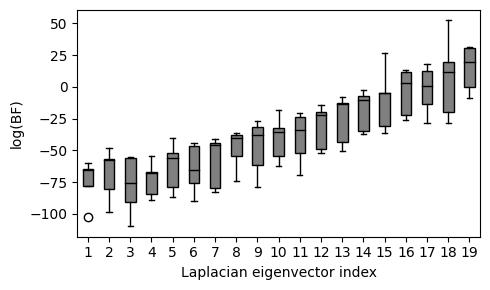

In [109]:
data_list = []

# Iterate over the replicates and K parameters
for replicate, k_dict in rep_dict.items():
    for laplacian_idx, bf_value in k_dict.items():
        data_list.append({'replicate': replicate, 'laplacian_idx': laplacian_idx, 'BF': bf_value})

# Create a DataFrame from the list
df = pd.DataFrame(data_list)
df = df[df['laplacian_idx'] != 0]

# Convert laplacian_idx to integer and sort the DataFrame
df['laplacian_idx'] = df['laplacian_idx'].astype(int)
df = df.sort_values(['laplacian_idx', 'replicate'])

# Get the sorted list of unique K parameters
k_parameters = sorted(df['laplacian_idx'].unique())

# Prepare the data for the boxplot
data_to_plot = [df[df['laplacian_idx'] == k]['BF'].values for k in k_parameters]
# data_to_plot = data_to_plot[1:len(data_to_plot)]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(5, 3))

# Create the boxplot
bp = ax.boxplot(data_to_plot, positions=[val+1 for val in range(len(k_parameters))], patch_artist=True)

# Customize the boxplot appearance
for box in bp['boxes']:
    box.set(facecolor='grey', edgecolor='black')

for whisker in bp['whiskers']:
    whisker.set(color='black')

for cap in bp['caps']:
    cap.set(color='black')

for median in bp['medians']:
    median.set(color='black')

# Overlay individual data points
for i, k in enumerate(k_parameters):
    y = df[df['laplacian_idx'] == k]['BF'].values
    x = np.random.normal(i, 0.04, size=len(y))  # Add jitter to prevent overlap
    


# Add labels and title
ax.set_xlabel('Laplacian eigenvector index')
ax.set_ylabel('log(BF)')

# Adjust layout
plt.tight_layout()
plt.savefig('figures/Figure_1/laplacian_eign_BF_boxplot.pdf')
plt.show()

In [111]:
# Group BF values by K_parameter
groups = [df[df['laplacian_idx'] == k]['BF'].values for k in k_parameters]

# Perform ANOVA
f_stat, p_value = stats.f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat}, p-value: {p_value}")

import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(df['BF'], df['laplacian_idx'])
post_hoc_res = comp.tukeyhsd()
print(post_hoc_res.summary())

ANOVA F-statistic: 10.453201934687074, p-value: 5.1876655718843036e-14
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2   5.9508    1.0 -40.8136  52.7152  False
     1      3  -3.3679    1.0 -50.1323  43.3965  False
     1      4   1.4741    1.0 -45.2903  48.2384  False
     1      5  11.5126    1.0 -35.2518   58.277  False
     1      6   9.9086    1.0 -36.8557   56.673  False
     1      7  15.4852 0.9993 -31.2792  62.2496  False
     1      8  25.5194 0.8825 -21.2449  72.2838  False
     1      9  26.7833 0.8354 -19.9811  73.5477  False
     1     10  33.4328 0.4882 -13.3316  80.1972  False
     1     11  34.2892 0.4414 -12.4751  81.0536  False
     1     12  42.6539 0.1168  -4.1105  89.4183  False
     1     13  48.6728 0.0325   1.9084  95.4371   True
     1     14  55.5939 0.0058   8.8295 102.3582   True
     1     15  64.2748 0.0005  17.5104 111.0392  

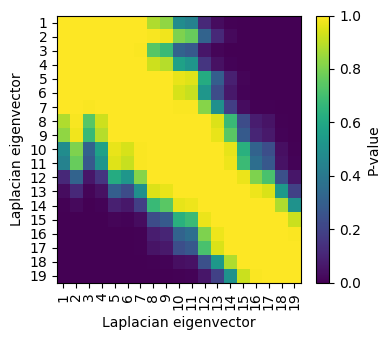

In [175]:
# Assuming post_hoc_res and related data have been set up properly
groups = list(post_hoc_res.groupsunique)
p_values = post_hoc_res.pvalues
post_hoc_res_df = pd.DataFrame(post_hoc_res.summary()).drop(0, axis=0)

# Create an empty matrix for storing p-values
matrix_size = len(groups)
p_matrix = np.ones((matrix_size, matrix_size))  # Initialize with 1s (since diagonal is self-comparison)

# Define group1 and group2 pairs based on the provided comparison order
group1 = [int(str(cell)) for cell in post_hoc_res_df[0]]
group2 = [int(str(cell)) for cell in post_hoc_res_df[1]]

# Fill in the p-values into the appropriate positions
for g1, g2, p in zip(group1, group2, p_values):
    idx1 = g1 - 1  # Convert to 0-based index
    idx2 = g2 - 1  # Convert to 0-based index
    p_matrix[idx1, idx2] = p
    p_matrix[idx2, idx1] = p  # Ensure symmetry

# Create a heatmap using imshow
fig, ax = plt.subplots(figsize=(4, 3.5))

im = ax.imshow(p_matrix, cmap='viridis', aspect='auto', vmin=0, vmax=1)

# Add a colorbar with a label
plt.colorbar(im, label='P-value', ax=ax)

# Add tick labels for the groups
plt.xticks(ticks=range(matrix_size), labels=groups, rotation=90)
plt.yticks(ticks=range(matrix_size), labels=groups)

# Add labels for better clarity
plt.xlabel('Laplacian eigenvector')
plt.ylabel('Laplacian eigenvector')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('figures/Figure_1/tukey_HSD_KNN_landscape.pdf')
plt.show()

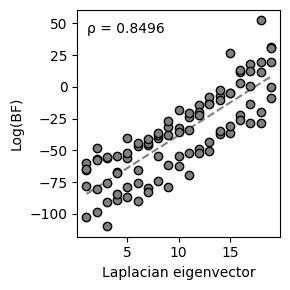

In [179]:


# Compute Spearman rho correlation
rho, p_value = spearmanr(df['laplacian_idx'], df['BF'])

# Fit a line of best fit (you can use np.polyfit for linear regression)
slope, intercept = np.polyfit(df['laplacian_idx'], df['BF'], 1)
best_fit_line = np.array(df['laplacian_idx']) * slope + intercept

fig = plt.subplots(figsize=(3, 3))

plt.xlabel('Laplacian eigenvector')
plt.ylabel('Log(BF)')

# Plot the line of best fit first (so it appears behind the scatter plot)
plt.plot(df['laplacian_idx'], best_fit_line, color='grey', linestyle='--', zorder=1)

# Scatter plot with color based on eigenvalue index
plt.scatter(df['laplacian_idx'], df['BF'], color='grey', linewidths=1, edgecolors='black')
plt.text(0.05, 0.9, f'ρ = {rho:.4f}', transform=plt.gca().transAxes, fontsize=10)

plt.tight_layout()
plt.savefig('figures/Figure_1/eigenvector_vs_BF_KNN_landscape.pdf')
plt.show()

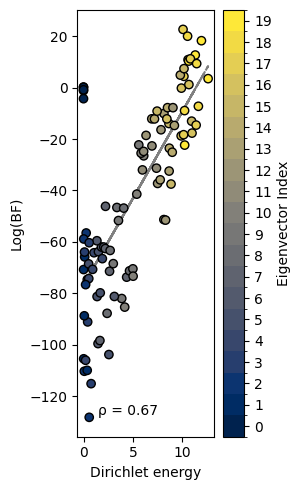

In [53]:
logp = []
de = []
eigs = []

for rep in rep_de_dict.keys():
    for eig in range(20):
        logp.append(rep_dict[rep][eig])
        de.append(rep_de_dict[rep][eig])
        eigs.append(eig)

# Compute Spearman rho correlation
rho, p_value = spearmanr(de, logp)

# Fit a line of best fit (you can use np.polyfit for linear regression)
slope, intercept = np.polyfit(de, logp, 1)
best_fit_line = np.array(de) * slope + intercept

# Discrete colormap setup
cmap = plt.get_cmap('cividis', np.max(eigs) - np.min(eigs) + 1)
norm = mcolors.BoundaryNorm(np.arange(np.min(eigs), np.max(eigs) + 2) - 0.5, cmap.N)

plt.figure(figsize=(3, 5))

plt.xlabel('Dirichlet energy')
plt.ylabel('Log(BF)')

# Plot the line of best fit first (so it appears behind the scatter plot)
plt.plot(de, best_fit_line, color='grey', linestyle='--', zorder=1)

# Scatter plot with color based on eigenvalue index
sc = plt.scatter(de, logp, c=eigs, cmap=cmap, norm=norm, linewidths=1, edgecolors='black', zorder=2)

# Adding a colorbar with integer values
cbar = plt.colorbar(sc, ticks=np.arange(np.min(eigs), np.max(eigs) + 1))
cbar.set_label('Eigenvector Index')

# Annotate the Spearman rho value in the bottom left corner
plt.text(0.15, 0.05, f'ρ = {rho:.2f}', transform=plt.gca().transAxes, fontsize=10)

plt.tight_layout()
plt.savefig('figures/Figure_1/BF_vs_de.pdf')
plt.show()

### Evolutionary parameter variable correlation against log(BF)

In [65]:
rep_sample_info_dict[0]

{'num_nodes': 307,
 'mean_branch_length': 0.05873355388813593,
 'std_dev_branch_length': 0.06867714053519401,
 'alpha': 0.36474879006867145,
 'model': 'LG',
 'sequence_length': 518}

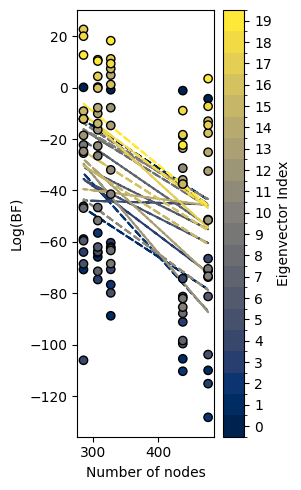

In [69]:
variable = 'num_nodes'

logp = []
var = []
eigs_ls = list(range(20))
eigs = []

for rep in rep_dict.keys():
    for eig in eigs_ls:
        logp.append(rep_dict[rep][eig])
        var.append(rep_sample_info_dict[rep][f'{variable}'])
        eigs.append(eig)


# Discrete colormap setup
cmap = plt.get_cmap('cividis', np.max(eigs) - np.min(eigs) + 1)
norm = mcolors.BoundaryNorm(np.arange(np.min(eigs), np.max(eigs) + 2) - 0.5, cmap.N)

plt.figure(figsize=(3, 5))

plt.xlabel(f'{variable}')
plt.xlabel('Number of nodes')
plt.ylabel('Log(BF)')

#Compute spearman rho for each eigenvector
for eig in eigs_ls:

    # Compute Spearman rho correlation
    rho, p_value = spearmanr(var[eig::10], logp[eig::10])

    # Fit a line of best fit (you can use np.polyfit for linear regression)
    slope, intercept = np.polyfit(var[eig::10], logp[eig::10], 1)
    best_fit_line = np.array(var[eig::10]) * slope + intercept

    # Plot the line of best fit first (so it appears behind the scatter plot)
    plt.plot(var[eig::10], best_fit_line, color=cmap(eig), linestyle='--', zorder=1)


# Scatter plot with color based on eigenvalue index
sc = plt.scatter(var, logp, c=eigs, cmap=cmap, norm=norm, linewidths=1, edgecolors='black', zorder=2)

# Adding a colorbar with integer values
cbar = plt.colorbar(sc, ticks=np.arange(np.min(eigs), np.max(eigs) + 1))

cbar.set_label('Eigenvector Index')

# Annotate the Spearman rho value in the bottom left corner
# plt.text(0.1, 0.9, f'ρ = {rho:.2f}', transform=plt.gca().transAxes, fontsize=10)
# plt.text(0.1, 0.825, f'p = {p_value:.2f}', transform=plt.gca().transAxes, fontsize=10)

plt.tight_layout()

plt.savefig('si_figures/logp_vs_evol_parameters/BF_vs_num_nodes.pdf')

plt.show()